In [1]:
pip install keras_applications 

Note: you may need to restart the kernel to use updated packages.


In [5]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from keras.layers.core import Lambda
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
#from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
import os
from keras.layers import *

In [6]:
def self_attention(input_feature, num_channel, base = 'self_attention_base'):
    bn_1 = BatchNormalization(axis = -1, name = base + '/bn_1')(input_feature)
    dense_1 = Dense(num_channel, name = base + '/dense_1')(bn_1)
    act_1 = Activation('relu', name = base + '/act_1')(dense_1)

    bn_2 = BatchNormalization(axis = -1, name = base + '/bn_2')(input_feature)
    dense_2 = Dense(num_channel, name = base + '/dense_2')(bn_2)
    act_2 = Activation('relu', name = base + '/act_2')(dense_2)

    bn_3 = BatchNormalization(axis = -1, name = base + '/bn_3')(input_feature)
    dense_3 = Dense(num_channel, name = base + '/dense_3')(bn_3)
    act_3 = Activation('relu', name = base + '/act_3')(dense_3)

    mul_1 = Multiply(name = base + '/mul_1')([act_2, act_3])
    mask_part = Activation('softmax', name = base + '/act_4')(mul_1)
    mul_2 = Multiply(name = base + '/mul_2')([act_1, mask_part])

    output_feature = Add(name = base + '/add_1')([mul_2, input_feature])

    return output_feature

def CMFA(input_feature, num_channel, base = 'CMFA_base'):
    out_1 = self_attention(input_feature, num_channel, base + '/self_att_1')
    out_2 = self_attention(input_feature, num_channel, base + '/self_att_2')
    out_3 = self_attention(input_feature, num_channel, base + '/self_att_3')
    out_4 = self_attention(input_feature, num_channel, base + '/self_att_4')

    output_feature = Add(name = base + '/add')([out_1, out_2, out_3, out_4])

    return output_feature

def SEM(input_feature, num_channel, base = 'SEM_base'):
    GAP_output = GlobalAveragePooling2D(name = base + '/gap_layer')(input_feature)

    bn_1 = BatchNormalization(axis = -1, name = base + '/bn_1')(GAP_output)
    dense_1 = Dense(int(num_channel/4), name = base + '/dense_1')(bn_1)
    act_1 = Activation('relu', name = base + '/act_1')(dense_1)

    bn_2 = BatchNormalization(axis = -1, name = base + '/bn_2')(act_1)
    dense_2 = Dense(num_channel, name = base + '/dense_2')(bn_2)
    act_2 = Activation('sigmoid', name = base + '/act_2')(dense_2)

    out_channel = Multiply(name = base + '/mul_1')([act_2, input_feature])

    strides = (1,1)

    bn_3 = BatchNormalization(axis = -1, name = base + '/bn_3')(input_feature)
    cn_3 = Conv2D(num_channel, (3,3), strides = strides, padding = 'same', name = base + '/conv_1')(bn_3)
    an_3 = Activation('relu', name = base + '/act_3')(cn_3)

    bn_4 = BatchNormalization(axis = -1, name = base + '/bn_4')(an_3)
    cn_4 = Conv2D(1, (1,1), strides = strides, padding = 'same', name = base + '/conv_2')(bn_4)
    an_4 = Activation('sigmoid', name = base + '/act_4')(cn_4)
    out_spatial = Multiply(name = base + '/mul_2')([an_4, input_feature])

    output_response = Add(name = base + '/add')([input_feature, out_channel, out_spatial])

    return output_response

def iDAAM(input_feature):
    shape=K.int_shape(input_feature)
    num_channel = shape[3]
    base = 'iDAAM'
    sem_feature = SEM(input_feature, num_channel)
    print(sem_feature.shape)
    cmfa_feature = CMFA(input_feature, num_channel)
    print(cmfa_feature.shape)
    attend_feature = tf.keras.layers.Add()([sem_feature,cmfa_feature])
    return attend_feature

In [3]:
def smooth_curve(points, factor=0.6):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    
   
def plotmodel(history,name):
    
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    #plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    #plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.legend(['train_acc'], loc='upper left')
    plt.savefig('acc_'+name+'idaam.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    #plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.legend(['train_loss'], loc='upper right')
    plt.savefig('loss_'+name+'idaam.png')
    
def get_base_model(model_name,image_size):
    if model_name =='vgg16':
        base_model=VGG16              (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='resnet50':
        base_model=tf.keras.applications.ResNet50           (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='xception':
        base_model=Xception           (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='densenet121':    #done acc = 55% epochs:30
        base_model=DenseNet121       (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='mobilenet0.75': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=0.75,input_shape=(image_size,image_size,3))
    if model_name =='mobilenet1.0': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='mobilenetv2':
        base_model=MobileNetV2      (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='inceptionv3':   
        base_model=InceptionV3       (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='inceptionv2':
        base_model=tf.keras.applications.InceptionResNetV2 (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    return base_model

def train_model(model,dataset,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):
    
    dataParam={'messidor': [960,240,2,'Messidor_Binary_512/train',
                            'Messidor_Binary_512/test'],
               'kaggle': [30000,5126,5,'./data/kaggle/train','./data/kaggle/valid'],
               'DDR':   [9851,2503,5,'./data/DDR/train','./data/DDR/valid']} 
    
    train_num,valid_num,classes,train_dir,test_dir = dataParam[dataset]
    
    train=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=90)          
    valid = ImageDataGenerator()
    train_data=train.flow_from_directory(train_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = True,
                                         batch_size=batch_size)
    valid_data=valid.flow_from_directory(test_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = False,
                                         batch_size=batch_size)

    lr_decay=ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1)
    #save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',period=10)
    
    filepath = "resnet50+iDAAM.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='acc',verbose=1, save_best_only=True, mode='max')

    for layer in base_model.layers:
        layer.trainable = False   
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr1,decay=0.00001),loss=loss_fun,metrics=['acc'])
    model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs1, 
                        workers=2,
                        callbacks=[lr_decay,checkpoint])   
    
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
    history=model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs2,
                        workers=2,
                        callbacks=[lr_decay,checkpoint])
    
    score = model.evaluate(valid_data,batch_size = 64)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return history,model,valid_data

In [7]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"    
loss_fun= 'binary_crossentropy'  
gpu_num=1
k=3
lr1=0.005
lr2=0.0001
batch_size= 16
image_size=512
classes=2

base_model=get_base_model('resnet50',image_size)  
base_in=base_model.input
base_out=base_model.output

shape = K.int_shape(base_out)
channel_val = shape[3]/2
#red_feat = tf.keras.layers.Conv2D(channel_val,1,padding='same')(base_out)
x=iDAAM(base_out)


shape=K.int_shape(x)  
x=GlobalAveragePooling2D()(x)
out=Dense(classes,activation='softmax')(x)

parallel_model=keras.Model(base_model.input,out)
parallel_model.summary()

2022-05-09 14:02:58.699746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1932] Ignoring visible gpu device (device: 1, name: GeForce GT 710, pci bus id: 0000:b3:00.0, compute capability: 3.5) with core count: 1. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2022-05-09 14:02:58.700206: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 14:02:59.374777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30677 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:65:00.0, compute capability: 7.0


(None, 16, 16, 2048)
(None, 16, 16, 2048)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                    

 conv2_block2_add (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 128, 128, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 128, 128, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 64, 64, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 64, 64, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 64, 64, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 64, 64, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 32, 32, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 32, 32, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

 conv5_block1_2_relu (Activatio  (None, 16, 16, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 16, 16, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 16, 16, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 16, 16, 2048  8192       ['conv5_block1_0_conv[0][0]']    
 ization) 

 SEM_base/bn_3 (BatchNormalizat  (None, 16, 16, 2048  8192       ['conv5_block3_out[0][0]']       
 ion)                           )                                                                 
                                                                                                  
 CMFA_base/self_att_1/bn_2 (Bat  (None, 16, 16, 2048  8192       ['conv5_block3_out[0][0]']       
 chNormalization)               )                                                                 
                                                                                                  
 CMFA_base/self_att_1/bn_3 (Bat  (None, 16, 16, 2048  8192       ['conv5_block3_out[0][0]']       
 chNormalization)               )                                                                 
                                                                                                  
 CMFA_base/self_att_2/bn_2 (Bat  (None, 16, 16, 2048  8192       ['conv5_block3_out[0][0]']       
 chNormali

 tivation)                      )                                [0]']                            
                                                                                                  
 CMFA_base/self_att_3/act_3 (Ac  (None, 16, 16, 2048  0          ['CMFA_base/self_att_3/dense_3[0]
 tivation)                      )                                [0]']                            
                                                                                                  
 CMFA_base/self_att_4/bn_1 (Bat  (None, 16, 16, 2048  8192       ['conv5_block3_out[0][0]']       
 chNormalization)               )                                                                 
                                                                                                  
 CMFA_base/self_att_4/act_2 (Ac  (None, 16, 16, 2048  0          ['CMFA_base/self_att_4/dense_2[0]
 tivation)                      )                                [0]']                            
          

                                                                                                  
 CMFA_base/self_att_1/mul_2 (Mu  (None, 16, 16, 2048  0          ['CMFA_base/self_att_1/act_1[0][0
 ltiply)                        )                                ]',                              
                                                                  'CMFA_base/self_att_1/act_4[0][0
                                                                 ]']                              
                                                                                                  
 CMFA_base/self_att_2/mul_2 (Mu  (None, 16, 16, 2048  0          ['CMFA_base/self_att_2/act_1[0][0
 ltiply)                        )                                ]',                              
                                                                  'CMFA_base/self_att_2/act_4[0][0
                                                                 ]']                              
          

In [8]:
history,model,valid_data=train_model(parallel_model,
                                     'messidor',
                                     image_size,
                                     batch_size,
                                     'resnet50',
                                     lr1,lr2,1,90)

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


2022-05-09 14:03:34.338208: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


60/60 [==============================] - ETA: 0s - loss: 1.9608 - acc: 0.6562
Epoch 1: acc improved from -inf to 0.65625, saving model to resnet50+iDAAM.hdf5
60/60 [==============================] - 45s 589ms/step - loss: 1.9608 - acc: 0.6562 - lr: 0.0050
Epoch 1/90
60/60 [==============================] - ETA: 0s - loss: 0.9662 - acc: 0.6854
Epoch 1: acc improved from 0.65625 to 0.68542, saving model to resnet50+iDAAM.hdf5
60/60 [==============================] - 52s 694ms/step - loss: 0.9662 - acc: 0.6854 - lr: 1.0000e-04
Epoch 2/90
60/60 [==============================] - ETA: 0s - loss: 0.6407 - acc: 0.7854
Epoch 2: acc improved from 0.68542 to 0.78542, saving model to resnet50+iDAAM.hdf5
60/60 [==============================] - 47s 763ms/step - loss: 0.6407 - acc: 0.7854 - lr: 1.0000e-04
Epoch 3/90
60/60 [==============================] - ETA: 0s - loss: 0.4931 - acc: 0.8240
Epoch 3: acc improved from 0.78542 to 0.82396, saving model to resnet50+iDAAM.hdf5
60/60 [=================

60/60 [==============================] - ETA: 0s - loss: 0.0237 - acc: 0.9906
Epoch 31: acc did not improve from 0.99063
60/60 [==============================] - 66s 1s/step - loss: 0.0237 - acc: 0.9906 - lr: 5.1200e-05
Epoch 32/90
60/60 [==============================] - ETA: 0s - loss: 0.0374 - acc: 0.9885
Epoch 32: acc did not improve from 0.99063
60/60 [==============================] - 68s 1s/step - loss: 0.0374 - acc: 0.9885 - lr: 5.1200e-05
Epoch 33/90
60/60 [==============================] - ETA: 0s - loss: 0.0458 - acc: 0.9875
Epoch 33: acc did not improve from 0.99063
60/60 [==============================] - 66s 1s/step - loss: 0.0458 - acc: 0.9875 - lr: 5.1200e-05
Epoch 34/90
60/60 [==============================] - ETA: 0s - loss: 0.0331 - acc: 0.9906
Epoch 34: ReduceLROnPlateau reducing learning rate to 4.0960000478662555e-05.

Epoch 34: acc did not improve from 0.99063
60/60 [==============================] - 66s 1s/step - loss: 0.0331 - acc: 0.9906 - lr: 5.1200e-05
Epoch

Epoch 64/90
60/60 [==============================] - ETA: 0s - loss: 0.0061 - acc: 0.9979
Epoch 64: ReduceLROnPlateau reducing learning rate to 1.0737417323980481e-05.

Epoch 64: acc did not improve from 1.00000
60/60 [==============================] - 63s 1s/step - loss: 0.0061 - acc: 0.9979 - lr: 1.3422e-05
Epoch 65/90
60/60 [==============================] - ETA: 0s - loss: 0.0087 - acc: 0.9990
Epoch 65: acc did not improve from 1.00000
60/60 [==============================] - 64s 1s/step - loss: 0.0087 - acc: 0.9990 - lr: 1.0737e-05
Epoch 66/90
60/60 [==============================] - ETA: 0s - loss: 0.0018 - acc: 1.0000
Epoch 66: acc did not improve from 1.00000
60/60 [==============================] - 64s 1s/step - loss: 0.0018 - acc: 1.0000 - lr: 1.0737e-05
Epoch 67/90
60/60 [==============================] - ETA: 0s - loss: 0.0017 - acc: 1.0000
Epoch 67: acc did not improve from 1.00000
60/60 [==============================] - 64s 1s/step - loss: 0.0017 - acc: 1.0000 - lr: 1.07

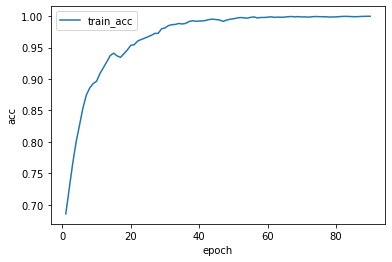

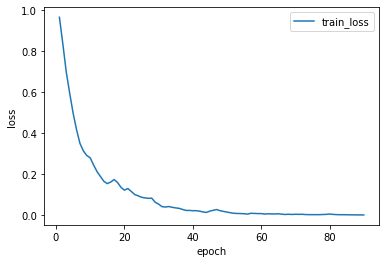

In [9]:
plotmodel(history,'resnet50')         

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

Y_pred = model.predict(valid_data, 240 // 4)
#print(Y_pred.shape)
#print(type(Y_pred))
print(valid_data.classes)  
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)
print('Confusion Matrix')
matrix = confusion_matrix(valid_data.classes, y_pred)

print(confusion_matrix(valid_data.classes, y_pred))
print('Classification Report')
target_names = ['non-referable', 'referable']
print(classification_report(valid_data.classes, y_pred, target_names=target_names))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[9.98714447e-01 1.28552213e-03]
 [9.99999762e-01 1.81940720e-07]
 [1.00000000e+00 8.31278868e-09]
 [1.00000000e+00 5.58936057e-12]
 [1.00000000e+00 7.16441462e-10]
 [1.00000000e+00 1.09799001e-11]
 [1.00000000e+00 3.08153154e-16]
 [7.18617055e-04 9.99281347e-01]
 [1.00000000e+00 3.42095987e-08]
 [9.99989390e-01 1.06518828e-05]
 [1.00000000e+00 2.70729041e-16]
 [1.00000000e+00 1.14250666e-11]
 [9.99999881e-01 1.66689659e-07]
 [1.00000000e+00 3.31637604e-13]
 [1.00000000e+00 1.46331856e-15]
 [9.97672737e-01 

Text(69.0, 0.5, 'Truth')

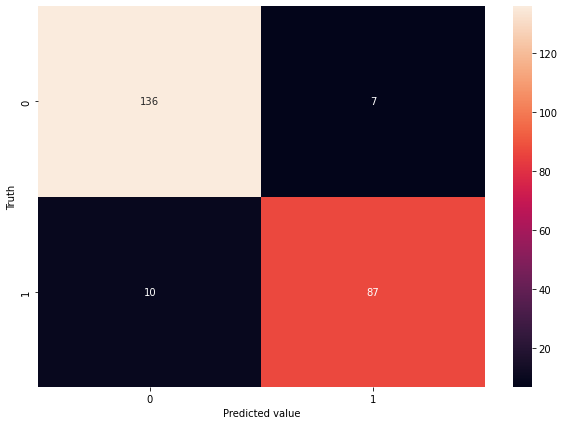

In [11]:
plt.figure(figsize = (10,7))
sn.heatmap(matrix,annot=True,fmt='d')
plt.xlabel('Predicted value')
plt.ylabel('Truth')   

In [12]:
pip install plot-metric

Note: you may need to restart the kernel to use updated packages.


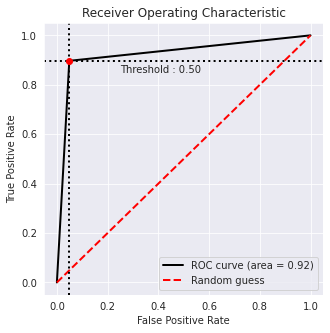

In [13]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
y_true = valid_data.classes
y_probas = y_pred
bc = BinaryClassification(y_true, y_probas, labels=['non-referable', 'referable'])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()